# Import Statements

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time as timer

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# Loading In Data

In [3]:
path_bird = 'DrawData/full_numpy_bitmap_bird.npy'
data_bird = np.load(path_bird)
bird_shape = data_bird.shape  #(N, 784)
print(f'Bird Data Shape:    {bird_shape}')

path_cat = 'DrawData/full_numpy_bitmap_cat.npy'
data_cat = np.load(path_cat)
cat_shape = data_cat.shape  #(N, 784)
print(f'Cat Data Shape:     {cat_shape}')

path_fish = 'DrawData/full_numpy_bitmap_fish.npy'
data_fish = np.load(path_fish)
fish_shape = data_fish.shape  #(N, 784)
print(f'Fish Data Shape:    {fish_shape}')

path_horse = 'DrawData/full_numpy_bitmap_horse.npy'
data_horse = np.load(path_horse)
horse_shape = data_horse.shape  #(N, 784)
print(f'Horse Data Shape:   {horse_shape}')

path_rabbit = 'DrawData/full_numpy_bitmap_rabbit.npy'
data_rabbit = np.load(path_rabbit)
rabbit_shape = data_rabbit.shape  #(N, 784)
print(f'Rabbit Data Shape:  {rabbit_shape}')

path_penguin = 'DrawData/full_numpy_bitmap_penguin.npy'
data_penguin = np.load(path_penguin)
penguin_shape = data_penguin.shape  #(N, 784)
print(f'Penguin Data Shape:  {penguin_shape}')

data = np.vstack((data_bird, data_cat, data_fish, data_horse, data_rabbit, data_penguin))
print(f'\nTotal Data Shape:   {data.shape}')
labels = np.array(['bird']*bird_shape[0] + ['cat']*cat_shape[0] + ['fish']*fish_shape[0] + ['horse']*horse_shape[0] + ['rabbit']*rabbit_shape[0] + ['penguin']*penguin_shape[0])
print(f'\nTotal Num. Of Samples: {labels.shape[0]}')

Bird Data Shape:    (133572, 784)
Cat Data Shape:     (123202, 784)
Fish Data Shape:    (134150, 784)
Horse Data Shape:   (178286, 784)
Rabbit Data Shape:  (155288, 784)
Penguin Data Shape:  (253791, 784)

Total Data Shape:   (978289, 784)

Total Num. Of Samples: 978289


# Hyperparams

In [4]:
#Learning Params
lr = 1e-4
num_epochs = 20
delta = 0.75
test_size = 0.1
val_size = 0.2
random_state = 42
batch_size = 8192

# CNN Network Definition

In [5]:
class DoodleCNN(nn.Module):
    def __init__(self):
        super(DoodleCNN, self).__init__()
        #Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1,      out_channels=4,        kernel_size=(5, 5),      padding=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=4,      out_channels=16,       kernel_size=(5, 5),      padding=(2, 2))
        self.conv3 = nn.Conv2d(in_channels=16,     out_channels=32,       kernel_size=(5, 5),      padding=(2, 2))
        self.conv4 = nn.Conv2d(in_channels=32,     out_channels=64,      kernel_size=(5, 5),      padding=(2, 2))

        self.batchnorm1 = nn.BatchNorm(num_features=16)
        self.batchnorm2 = nn.BatchNorm(num_features=64)
        self.batchnorm3 = nn.BatchNorm(num_features=128)
        
        #MaxPooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        #Fully connected layers
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 5)
        
        #Dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        #Convolutional layers with SELU activations and MaxPooling
        x = F.selu(self.conv1(x))
        x = self.pool(self.batchnorm1(F.selu(self.conv2(x))))
        x = F.selu(self.conv3(x))
        x = self.pool(self.batchnorm2(F.selu(self.conv4(x))))
        
        x = x.view(-1, 64*7*7)
        #Fully connected layers with LeakyReLU activations and Dropout
        x = self.batchnorm3(F.leaky_relu(self.fc1(x)))
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Custom Dataset Definition

In [6]:
class DoodleDataset(Dataset):
	def __init__(self, data, labels, transform=None):
		self.data = data
		self.labels = labels
		self.transform = transform
		self.label_to_idx = {'bird': 0, 'cat': 1, 'fish': 2, 'horse': 3, 'rabbit': 4, 'penguin': 5}

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		image = self.data[idx].reshape(28, 28).astype(np.float32)/255.0  # Normalize pixel values
		label = self.label_to_idx[self.labels[idx]]
		
		if self.transform:
			image = self.transform(image)
		
		image = torch.tensor(image).unsqueeze(0)  # Add channel dimension
		label = torch.tensor(label).long()
		
		return image, label

# Setup Training, Validation, & Testing Dataloaders

In [7]:
#Split data into training, validation, and testing sets
X_train, X_valtest, y_train, y_valtest = train_test_split(data, labels, test_size=(test_size + val_size), random_state=random_state, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=(test_size/(test_size + val_size)), random_state=random_state, stratify=y_valtest)

# Setup Training, Validation, & Testing Dataloaders
train_dataset = DoodleDataset(X_train, y_train)
val_dataset = DoodleDataset(X_val, y_val)
test_dataset = DoodleDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Train Function

In [8]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    #Setup model history tracking
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'test_loss': None, 'test_acc': None}
    
    for epoch in range(num_epochs):
        #Training
        model.train()
        train_running_loss = 0.0
        train_running_corrects = 0
        for image, label in dataloaders['train']:
            image = image.to(device)
            label = label.to(device)
            
            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_running_loss += loss.item()*image.size(0)
            train_running_corrects += torch.sum(preds == label.data)
            
        train_epoch_loss = train_running_loss/dataset_sizes['train']
        train_epoch_acc = train_running_corrects.double()/dataset_sizes['train']
        scheduler.step()
        
        #Validation
        model.eval()
        with torch.no_grad():
            val_running_loss = 0.0
            val_running_corrects = 0
            for image, label in dataloaders['val']:
                image = image.to(device)
                label = label.to(device)
                
                outputs = model(image)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, label)
                
                val_running_loss += loss.item()*image.size(0)
                val_running_corrects += torch.sum(preds == label.data)
            
            val_epoch_loss = val_running_loss/dataset_sizes['val']
            val_epoch_acc = val_running_corrects.double()/dataset_sizes['val']
        
        #Printouts & appends
        print(f'|    Epoch:  [{epoch+1:2}]/[{num_epochs:2}]    |    '
              f'Train Loss:  [{train_epoch_loss:.4f}]    |    Train Acc:  [{train_epoch_acc:.4f}]    |    '
              f'Val Loss:  [{val_epoch_loss:.4f}]    |    Val Acc:  [{val_epoch_acc:.4f}]    |')
        history['train_loss'].append(train_epoch_loss)
        history['train_acc'].append(train_epoch_acc.item())
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())
        
    #Testing
    model.eval()
    with torch.no_grad():
        test_running_loss = 0.0
        test_running_corrects = 0
        for image, label in dataloaders['test']:
            image = image.to(device)
            label = label.to(device)
            
            outputs = model(image)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, label)
            
            test_running_loss += loss.item()*image.size(0)
            test_running_corrects += torch.sum(preds == label.data)
            
        test_epoch_loss = test_running_loss/dataset_sizes['test']
        test_epoch_acc = test_running_corrects.double()/dataset_sizes['test']
    
    #Printouts & appends
    print(f'Test Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.4f}')
    history['test_loss'] = test_epoch_loss
    history['test_acc'] = test_epoch_acc.item()
    
    return model, history

# Train Model

In [ ]:
#Training Setup
model = DoodleCNN().to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=delta)
trained_model, history = train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=num_epochs)

|    Epoch:  [ 1]/[20]    |    Train Loss:  [1.1637]    |    Train Acc:  [0.5392]    |    Val Loss:  [0.7897]    |    Val Acc:  [0.7237]    |
|    Epoch:  [ 2]/[20]    |    Train Loss:  [0.6894]    |    Train Acc:  [0.7633]    |    Val Loss:  [0.5536]    |    Val Acc:  [0.8118]    |
|    Epoch:  [ 3]/[20]    |    Train Loss:  [0.5547]    |    Train Acc:  [0.8128]    |    Val Loss:  [0.4975]    |    Val Acc:  [0.8302]    |
|    Epoch:  [ 4]/[20]    |    Train Loss:  [0.5088]    |    Train Acc:  [0.8286]    |    Val Loss:  [0.4664]    |    Val Acc:  [0.8401]    |
|    Epoch:  [ 5]/[20]    |    Train Loss:  [0.4831]    |    Train Acc:  [0.8368]    |    Val Loss:  [0.4482]    |    Val Acc:  [0.8459]    |
|    Epoch:  [ 6]/[20]    |    Train Loss:  [0.4674]    |    Train Acc:  [0.8416]    |    Val Loss:  [0.4369]    |    Val Acc:  [0.8495]    |
|    Epoch:  [ 7]/[20]    |    Train Loss:  [0.4562]    |    Train Acc:  [0.8458]    |    Val Loss:  [0.4286]    |    Val Acc:  [0.8522]    |
|    E

In [ ]:
# #Save Model Weights
# torch.save(trained_model.state_dict(), 'doodle_cnn_model.pth')

# Analyze Results

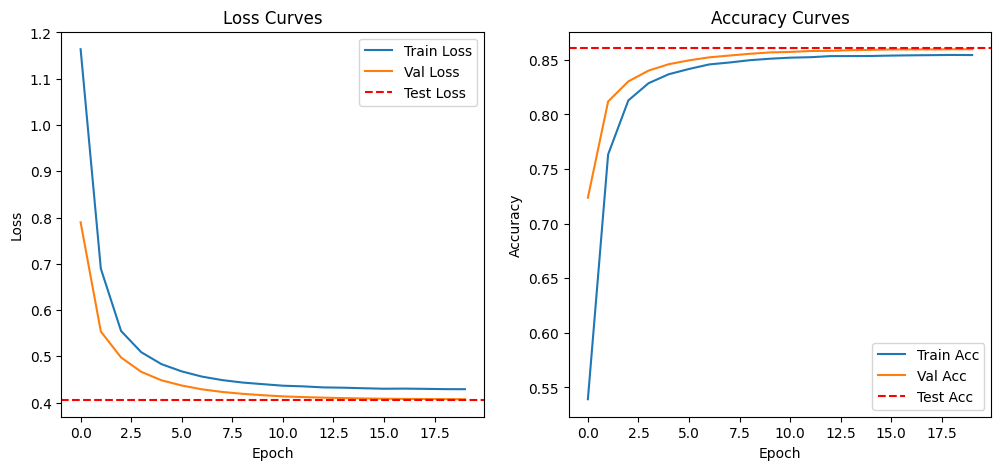

In [ ]:
# #Plot Loss and Accuracy Curves
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# ax1.plot(history['train_loss'], label='Train Loss')
# ax1.plot(history['val_loss'], label='Val Loss')
# ax1.axhline(history['test_loss'], color='r', linestyle='--', label='Test Loss')
# ax1.set_title('Loss Curves')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Loss')
# ax1.legend()

# ax2.plot(history['train_acc'], label='Train Acc')
# ax2.plot(history['val_acc'], label='Val Acc')
# ax2.axhline(history['test_acc'], color='r', linestyle='--', label='Test Acc')
# ax2.set_title('Accuracy Curves')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Accuracy')
# ax2.legend()

# fig.savefig('training_history.png', dpi=96, bbox_inches='tight')

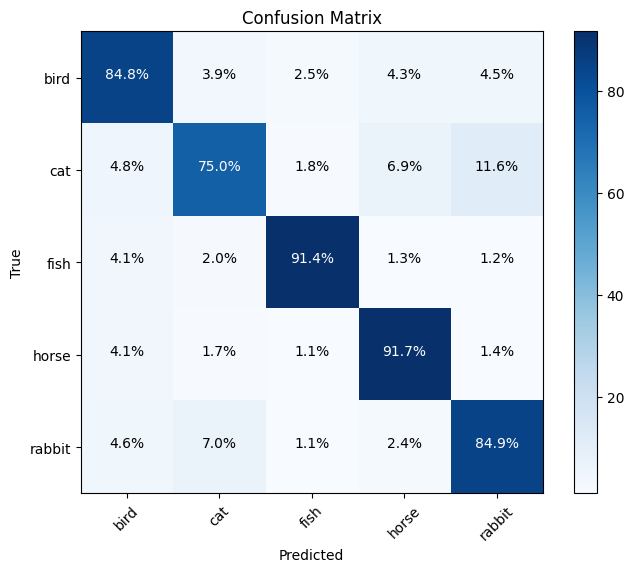

In [ ]:
# # Plot Confusion Matrix
# def plot_confusion_matrix(model, dataloader, classes):
#     from sklearn.metrics import confusion_matrix

#     model.eval()
#     all_preds = []
#     all_labels = []
    
#     with torch.no_grad():
#         for images, labels in dataloader:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
    
#     cm = confusion_matrix(all_labels, all_preds)
#     cm_percent = np.round(100*cm.astype('float')/cm.sum(axis=1)[:, np.newaxis], 1)
#     plt.figure(figsize=(8, 6))
#     plt.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)
#     for i in range(len(classes)):
#         for j in range(len(classes)):
#             plt.text(j, i, f'{cm_percent[i, j]}%', horizontalalignment="center", color="white" if cm_percent[i, j] > cm_percent.max()/2. else "black")
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.savefig('confusion_matrix.png', dpi=96, bbox_inches='tight')

# plot_confusion_matrix(trained_model, dataloaders['test'], classes=['bird', 'cat', 'fish', 'horse', 'rabbit'])

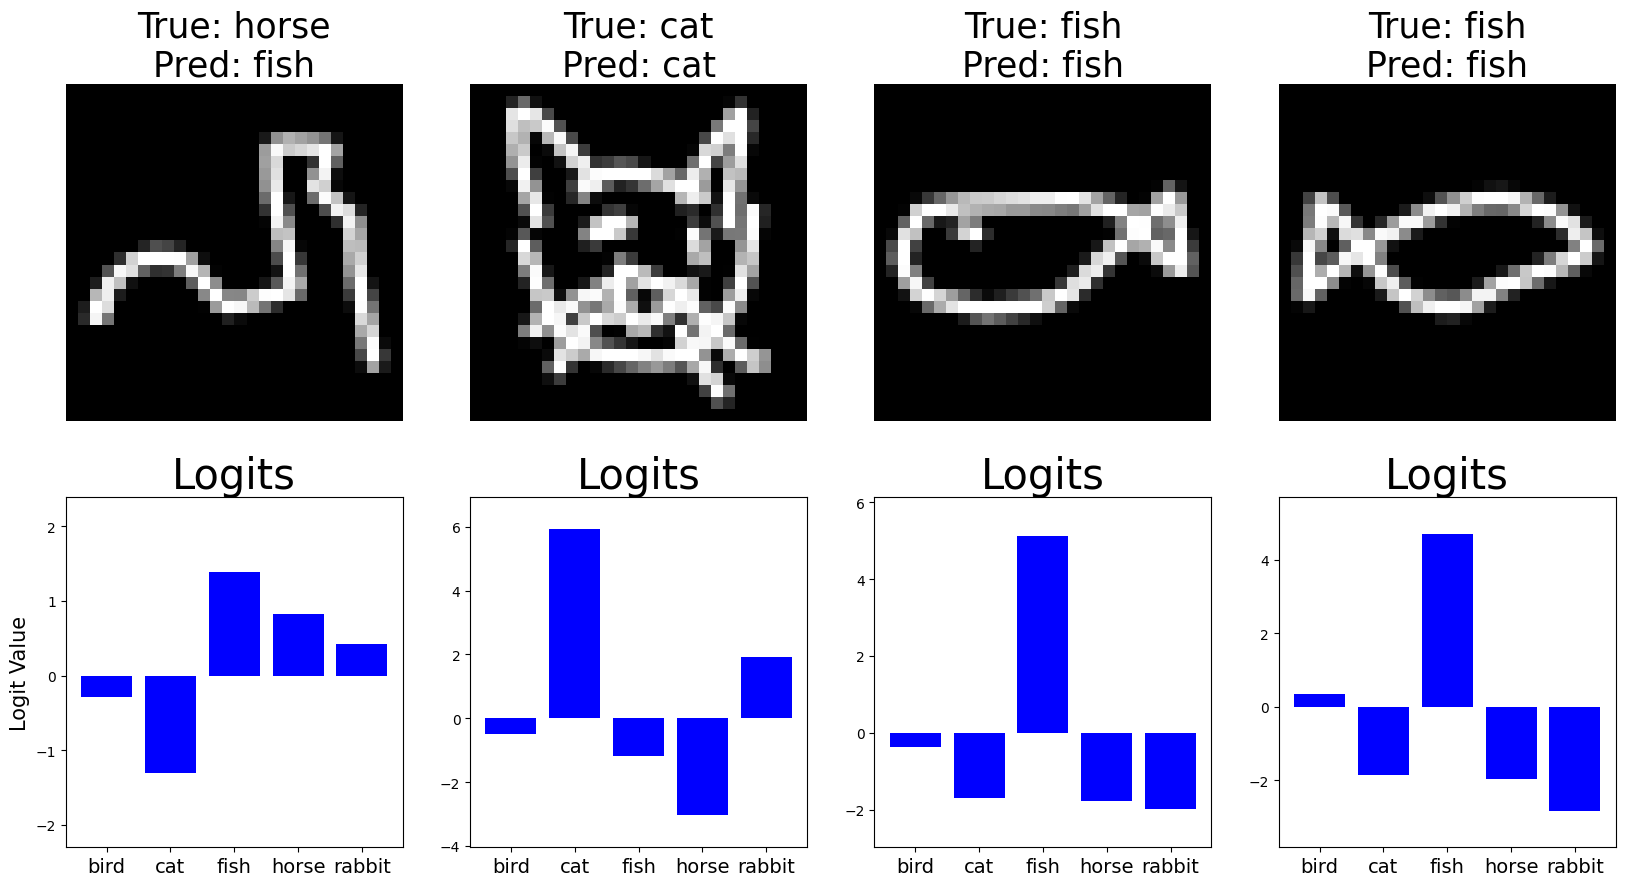

In [ ]:
# # Show some examples with logits
# def show_examples_with_logits(model, dataloader, classes, num_examples=4):
#     fig, axes = plt.subplots(2, num_examples, figsize=(5*num_examples, 10))
    
#     Label_fs = 25
#     Ltitle_fs = 30
#     Llabels_fs = 14
#     lylabel_fs = 15
    
#     model.eval()
#     axes[1, 0].set_ylabel('Logit Value', fontsize=lylabel_fs)
#     examples_shown = 0
#     with torch.no_grad():
#         for images, labels in dataloader:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             _, preds = torch.max(outputs, 1)
            
#             for i in range(images.size(0)):
#                 if examples_shown >= num_examples:
#                     break
#                 img = images[i].cpu().squeeze().numpy()
#                 true_label = classes[labels[i].item()]
#                 pred_label = classes[preds[i].item()]
#                 logits = np.round(outputs[i].cpu().numpy(),2)
                
#                 #Add example to top row
#                 axes[0, examples_shown].imshow(img, cmap='gray')
#                 axes[0, examples_shown].set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=Label_fs)
#                 axes[0, examples_shown].axis('off')
                
#                 #Add Bar chart to bottom row
#                 axes[1, examples_shown].bar(classes, logits, color='blue')
#                 axes[1, examples_shown].set_title('Logits', fontsize=Ltitle_fs)
#                 axes[1, examples_shown].set_ylim([min(logits)-1, max(logits)+1])
#                 axes[1, examples_shown].tick_params(axis='x', labelsize=Llabels_fs)
#                 examples_shown += 1
#             if examples_shown >= num_examples:
#                 break
#     fig.savefig('examples_with_logits.png', dpi=96, bbox_inches='tight')

# show_examples_with_logits(trained_model, dataloaders['test'], classes=['bird', 'cat', 'fish', 'horse', 'rabbit'], num_examples=4)

# Tensorflow Model

In [11]:
import sys
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"

!{sys.executable} -m pip install 'tensorflow[and-cuda]<2.16' 'tensorflowjs[wizard]<4.20'

ERROR: Could not find a version that satisfies the requirement tensorflow<2.16 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: /home/theel/.pyenv/versions/3.12.11/bin/python -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow<2.16


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#Learning Params
lr = 1e-4
num_epochs = 20
delta = 0.75
test_size = 0.2
validation_split = 0.1
batch_size = 4096

In [ ]:
print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Found GPUs: {gpus}")
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Success! TensorFlow will use the GPU.")
    except RuntimeError as e:
        print(e)
else:
    print("FAILURE: No GPU was found by TensorFlow.")
    print("Training will be on the CPU (which will be very slow).")

TensorFlow Version: 2.19.0
Found GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Success! TensorFlow will use the GPU.


In [ ]:
!nvidia-smi

Sat Nov 15 15:36:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0 Off |                  Off |
|  0%   36C    P5             20W /  450W |    9144MiB /  24564MiB |     33%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#Split data into training and testing sets
classes = np.unique(labels)
num_classes = len(classes)
label_map = {label: idx for idx, label in enumerate(classes)}
num_labels = np.array([label_map[label] for label in labels])
data_res = data.reshape(-1, 28, 28, 1).astype(np.float32)/255.0
X_train, X_test, y_train, y_test = train_test_split(data_res, num_labels, test_size=test_size, stratify=labels)

num_train_samples = len(X_train) * (1.0 - validation_split)
steps_per_epoch = np.ceil(num_train_samples / batch_size)
decay_steps = int(steps_per_epoch * num_epochs)

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=lr,
    decay_steps=decay_steps,
    alpha=0.0
)

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

#Define TensorFlow CNN Model
model = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
	layers.Conv2D(4, (5, 5), padding='same', activation='selu'),
	layers.Conv2D(16, (5, 5), padding='same', activation='selu'),
	layers.BatchNormalization(),
	layers.MaxPooling2D((2, 2)),
	layers.Conv2D(32, (5, 5), padding='same', activation='selu'),
	layers.Conv2D(64, (5, 5), padding='same', activation='selu'),
	layers.BatchNormalization(),
	layers.MaxPooling2D((2, 2)),
	layers.Flatten(),
	layers.Dense(128, activation='leaky_relu'),
	layers.BatchNormalization(),
	layers.Dense(64, activation='leaky_relu'),
	layers.Dropout(0.25),
	layers.Dense(num_classes)
])

#Display Model Summary
model.summary()

#Compile and Train the Model
model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=validation_split)

#Save the Model
model.save("my_mnist_cnn_v4.h5")
print("Model saved as my_mnist_cnn_v4.h5")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 4)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 16)     │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 475,933 (1.82 MB)

 Trainable params: 475,933 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6788 - loss: 0.8834 - val_accuracy: 0.8207 - val_loss: 0.5421
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8295 - loss: 0.5041 - val_accuracy: 0.8565 - val_loss: 0.4253
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8557 - loss: 0.4265 - val_accuracy: 0.8704 - val_loss: 0.3813
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8679 - loss: 0.3905 - val_accuracy: 0.8779 - val_loss: 0.3579
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8759 - loss: 0.3660 - val_accuracy: 0.8847 - val_loss: 0.3409
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8816 - loss: 0.3499 - val_accuracy: 0.8897 - val_loss: 0.3277
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8860 - loss: 0.3367 - val_accuracy: 0.8931 - val_loss: 0.3180
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8896 - loss: 0.3259 - val_accu

Model saved as my_mnist_cnn_v4.h5


In [ ]:
import subprocess

model.export("my_mnist_cnn_v4_savedmodel_legacy")
print("Model saved as my_mnist_cnn_v4_savedmodel_legacy")
model.save("my_mnist_cnn_v4_legacy.h5")
print("Model saved as my_mnist_cnn_v4_legacy.h5")
model.save("my_mnist_cnn_v4_legacy.keras")
print("Model saved as my_mnist_cnn_v4_legacy.keras")

subprocess.run("tensorflowjs_converter --input_format=keras Cnn/my_mnist_cnn_v4_legacy.h5 ./tfjs_model")

INFO:tensorflow:Assets written to: my_mnist_cnn_v4_savedmodel_legacy/assets


INFO:tensorflow:Assets written to: my_mnist_cnn_v4_savedmodel_legacy/assets


Saved artifact at 'my_mnist_cnn_v4_savedmodel_legacy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_36')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  124465099823184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124465099824720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124465099826256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124465099825488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124465099826640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124465099826448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124465099827024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124465099826832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124465099827408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  124465099827216: TensorSpec(shape=(), dtype=tf.resource, name=None

Model saved as my_mnist_cnn_v4_savedmodel_legacy
Model saved as my_mnist_cnn_v4_legacy.h5
Model saved as my_mnist_cnn_v4_legacy.keras


# TODO

* Add Timing